In [9]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.style as style
import seaborn as sns
style.use('seaborn')
sns.set_style(style='darkgrid')
import numpy as np
import pandas as pd
from scipy import spatial
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import gensim 
import gensim.downloader as api
from gensim.models import Word2Vec 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from MulticoreTSNE import MulticoreTSNE as MultiTSNE
import timeit
import pickle
import warnings
warnings.filterwarnings('ignore')

In [10]:
subreddits = pd.read_csv('data/allsubreddits_10000.csv')
comments = subreddits['body']
subreddits = subreddits['subreddit']

In [11]:
mask = np.concatenate((np.where(subreddits=='AnimalsBeingDerps')[0],np.where(subreddits=='nfl')[0],np.where(subreddits=='politics')[0]))

In [12]:
def get_w2v_general(comment, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in comment.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [13]:
with open('data/glove_twitter_200.pkl', 'rb') as f:
    glove_twitter = pickle.load(f)

In [14]:
data = pd.read_pickle('data/cleaned_text_10000.pkl')
data = data.values

In [15]:
data = data[mask][0:-1:10]

In [16]:
start_time = timeit.default_timer()
X = scale(np.concatenate([get_w2v_general(z, 200, glove_twitter,'mean') for z in data]))
print((timeit.default_timer() - start_time)/60,'minutes')

0.009974485850004081 minutes


In [17]:
clusterer = KMeans(n_clusters=3, verbose=1, n_jobs=-1, random_state=1)
cluster_labels = clusterer.fit_predict(X)

In [18]:
tsne = MultiTSNE(n_components=2,perplexity=50,verbose=1,n_jobs=64,random_state=1)
start_time = timeit.default_timer()
X_tsne = tsne.fit_transform(X)
print((timeit.default_timer() - start_time)/60,'minutes')

0.2705087938333236 minutes


0.17789322025000728 minutes


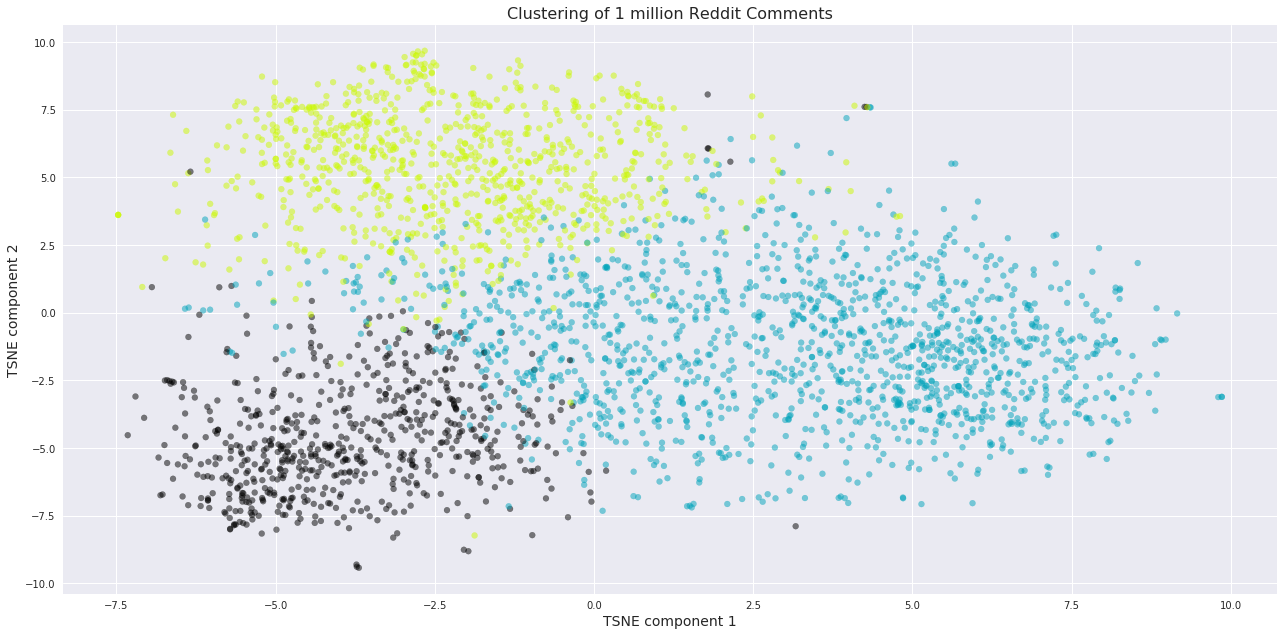

In [19]:
matplotlib.rcParams.update({'font.size': 12})
for n_clusters in [3]:
    start_time = timeit.default_timer()
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 9)

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters, verbose=1, n_jobs=-1, random_state=1)
    #cluster_labels = clusterer.fit_predict(X_tsne)

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s=35,
                c=colors)

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')

    ax.set_title('Clustering of 1 million Reddit Comments', {'fontsize': 16})
    ax.set_xlabel('TSNE component 1', {'fontsize': 14})
    ax.set_ylabel('TSNE component 2', {'fontsize': 14})
    
    plt.tight_layout()
    fig.savefig('plots/kmeansproof.png', dpi=640)
    print((timeit.default_timer() - start_time)/60,'minutes')

In [42]:
with open('data/doc2vec_feature_matrix_10000.pkl', 'rb') as f:
    X = pickle.load(f)

In [43]:
#X = X[0:-1:100]

In [44]:
start_time = timeit.default_timer()
clusterer = KMeans(n_clusters=61, verbose=1, n_jobs=-1, random_state=1)
cluster_labels = clusterer.fit_predict(X)
print((timeit.default_timer() - start_time)/60,'minutes')

45.70552803431668 minutes


In [45]:
with open('data/tsne_matrix_10000_perplex_50.pkl', 'rb') as f:
    X_tsne = pickle.load(f)

In [46]:
#X_tsne = X_tsne[0:-1:100]

2.2971507677666523 minutes


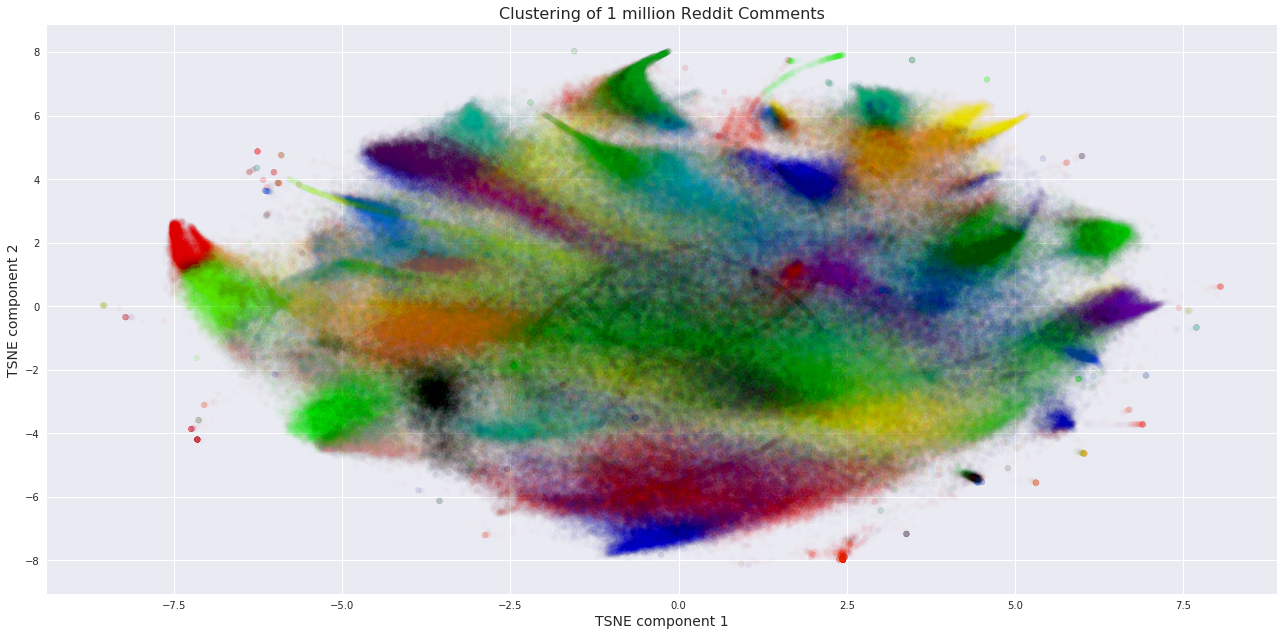

In [50]:
matplotlib.rcParams.update({'font.size': 12})
for n_clusters in [61]:
    start_time = timeit.default_timer()
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 9)

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters, verbose=1, n_jobs=-1, random_state=1)
    #cluster_labels = clusterer.fit_predict(X_tsne)

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.01, s=35,
                c=colors)

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax.scatter(centers[:, 0], centers[:, 1], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')

    ax.set_title('Clustering of 1 million Reddit Comments', {'fontsize': 16})
    ax.set_xlabel('TSNE component 1', {'fontsize': 14})
    ax.set_ylabel('TSNE component 2', {'fontsize': 14})
    
    plt.tight_layout()
    fig.savefig('plots/kmeansprior.png', dpi=640)
    print((timeit.default_timer() - start_time)/60,'minutes')

In [53]:
start_time = timeit.default_timer()
indexes=[]
for i in range(clusterer.cluster_centers_.shape[0]):
    distance, index = spatial.KDTree(X).query(clusterer.cluster_centers_[i],10)
    indexes.append(index)
print((timeit.default_timer() - start_time)/60,'minutes')

41.884618377900004 minutes


In [61]:
comments[indexes[0]].values

array(['Of course!\n\nNothing to be nervous about, friend, just sit back and enjoy the comment!\n\nThere are quite a few touristy things I\'d recommend doing, these are a few you could look into:\n\n* Anything to do with Table Mountain, Lion\'s Head (cable car, hiking, restaurant on the mountain) and Signal Hill (you can paraglide off Signal Hill by the way)\n* Visiting our beautiful wine farms out in Stellenbosch and Franschhoek\n* Visiting our beautiful beaches (Clifton 1st and 4th beaches, Blouberg and Big Bay beach, Llandudno beach, Glen beach to name a few)\n* Going to see the penguins! (At Boulder\'s beach, it\'s in Simonstown, where our biggest naval base is, and one of the most beautiful places)\n* One of the highest bungie jumps in the world,  Bloukrans Bridge (outside Cape Town but still in the province)\n* Kirstenbosch Botanical Gardens (there\'s a tree top canopy walk here), Cape Point Nature Reserve and Company\'s Garden (lots of squirrels to feed here, they even walk on y